# Getting Insights

In [ ]:
#| echo: false

from census import Census
import pandas as pd
import os
import cenpy
import altair as alt
import geopandas as gpd
import hvplot.pandas
import numpy as np
import seaborn as sns
import pygris
from matplotlib import pyplot as plt

%store -r aggregated_with_canopy_full
%store -r census_data

## 2.1. Combining All Data Sets

In [8]:
# Ensure both data frames have a common key column, e.g., "GEOID"
if "GEOID" not in aggregated_with_canopy_full.columns or "GEOID" not in census_data.columns:
    raise KeyError("Both data frames must contain a 'GEOID' column for merging.")

# Merge the two data frames
combined_data = pd.merge(
    census_data,
    aggregated_with_canopy_full,
    on="GEOID",
    how="outer",  # Use 'outer' to retain all data; use 'inner' for only matching rows
    suffixes=('', '_canopy')  # Add suffix to distinguish overlapping column names
)


## 2.2. Log Transformation of Median Household Income

The log transformation is applied to the `Median Household Income` variable to address potential skewness in the data. Income distributions are often right-skewed, meaning that a small number of observations with very high incomes can disproportionately influence the analysis. By applying a log transformation, we can:

- Reduce the impact of extreme values, making the data more normally distributed.

- Enhance the interpretability of relationships, as percentage changes in income are often more meaningful than absolute changes.

- Improve the performance of statistical models and clustering algorithms, which often assume normality or are sensitive to outliers.

The resulting `Log_Median_Household_Income` variable is used in subsequent analyses to ensure robust and meaningful insights.
hts.





In [ ]:
#| warning: false

# Create a new column with the logged values of "Median_Household_Income"
# Use np.log1p to handle zeros and avoid -inf errors
combined_data["Log_Median_Household_Income"] = np.log1p(combined_data["Median_Household_Income"])

## 2.3. Scatter Plot Analysis

We examined the relationships between socioeconomic, demographic, and environmental health indicators. The analysis revealed significant correlations, shedding light on areas of concern and the interplay between various factors. The analysis focused on the following variables:

- **Independent Variables**:
  - `Perc_Non_White`
  - `Perc_Dependent_Pop`
  - `Perc_Edu_HS_Higher`
  - `Log_Median_Household_Income`(Logged)
  
- **Dependent Variables**:
  - `Percentage of Children with Lead Exposure`
  - `Percentage of Adults with Asthma`
  - `Percentage of Adults with Cancer`
  - `Heat Vulnerability Index Score`


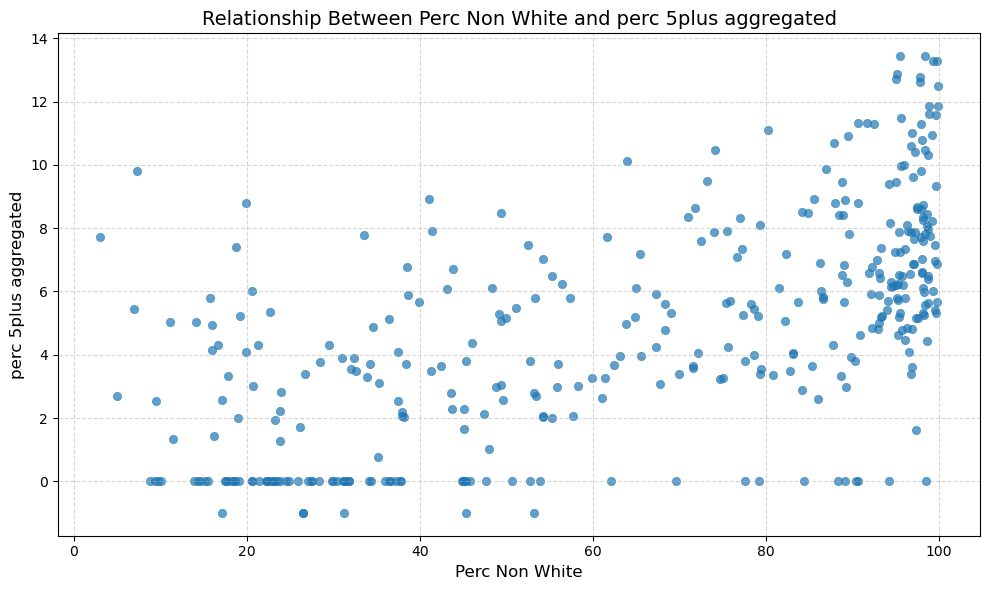

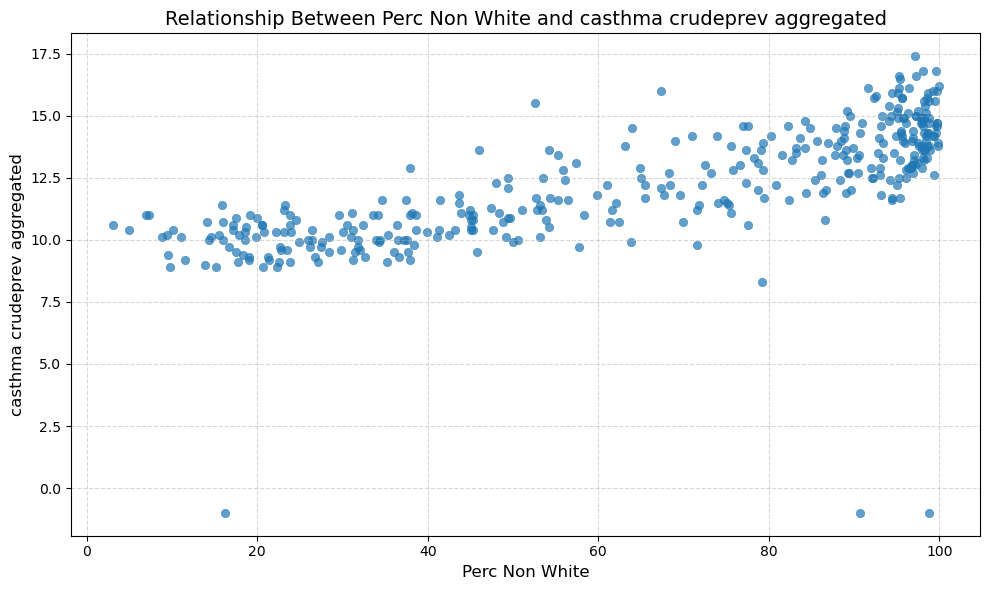

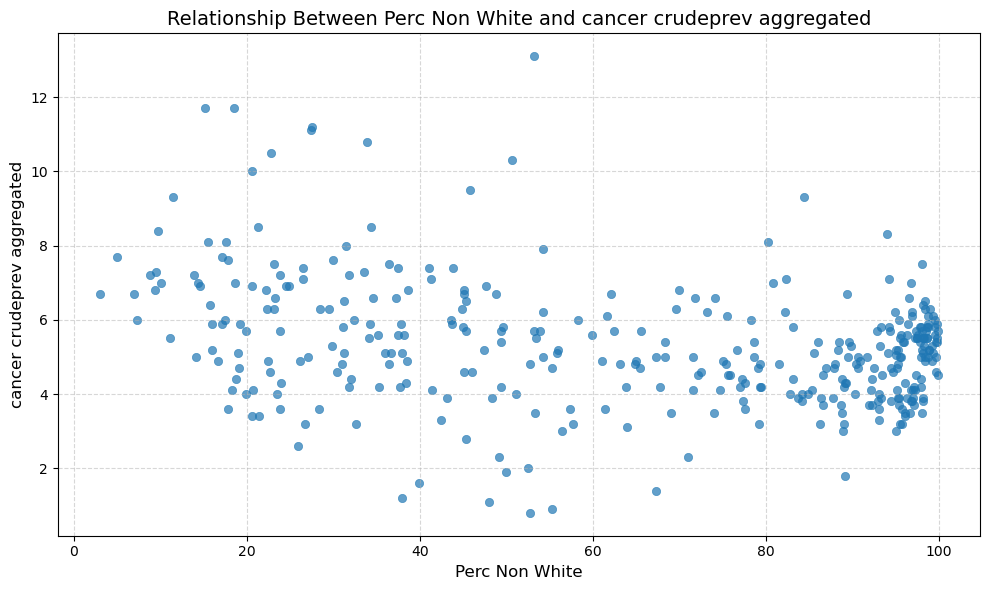

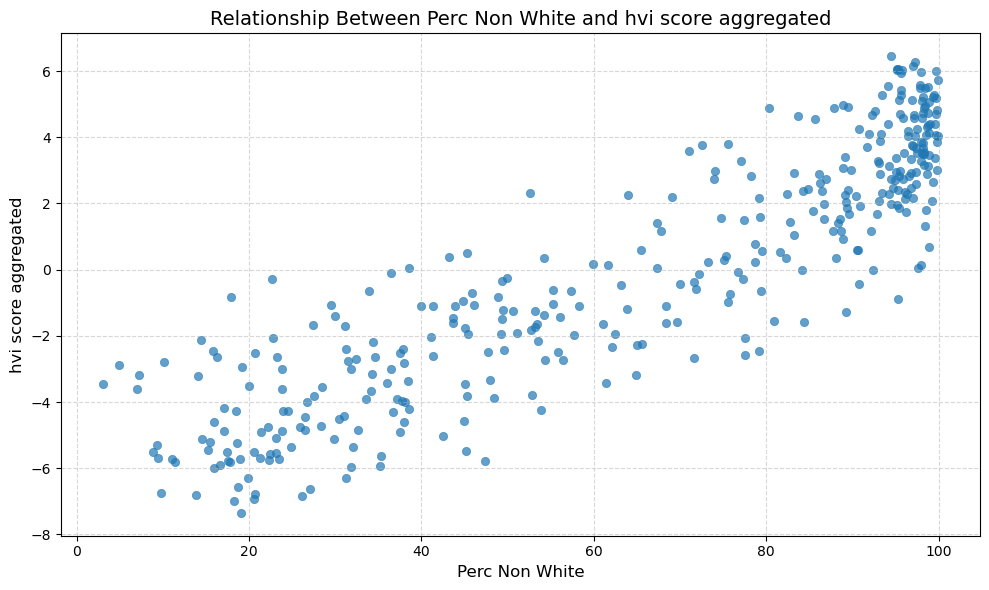

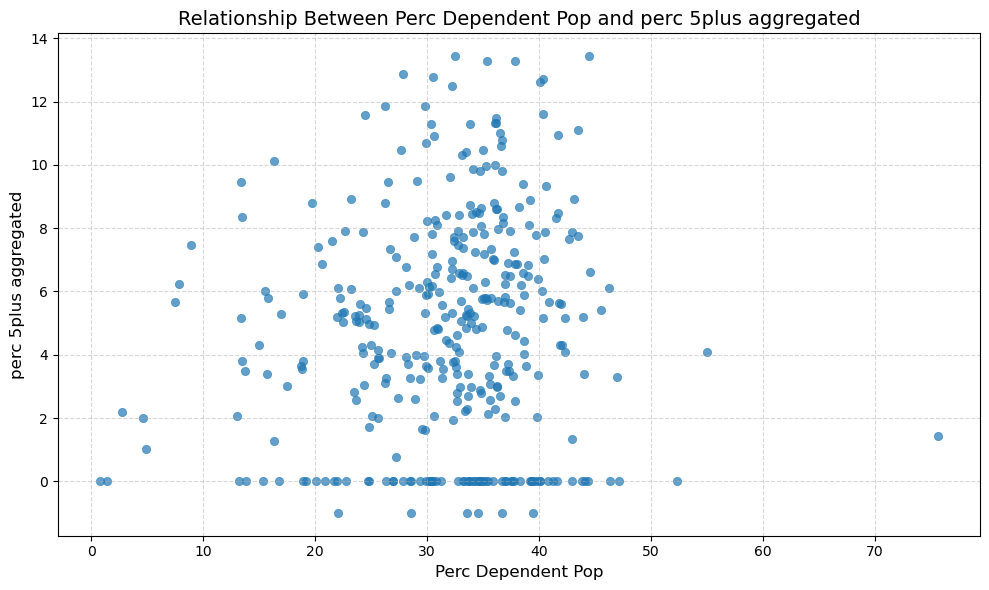

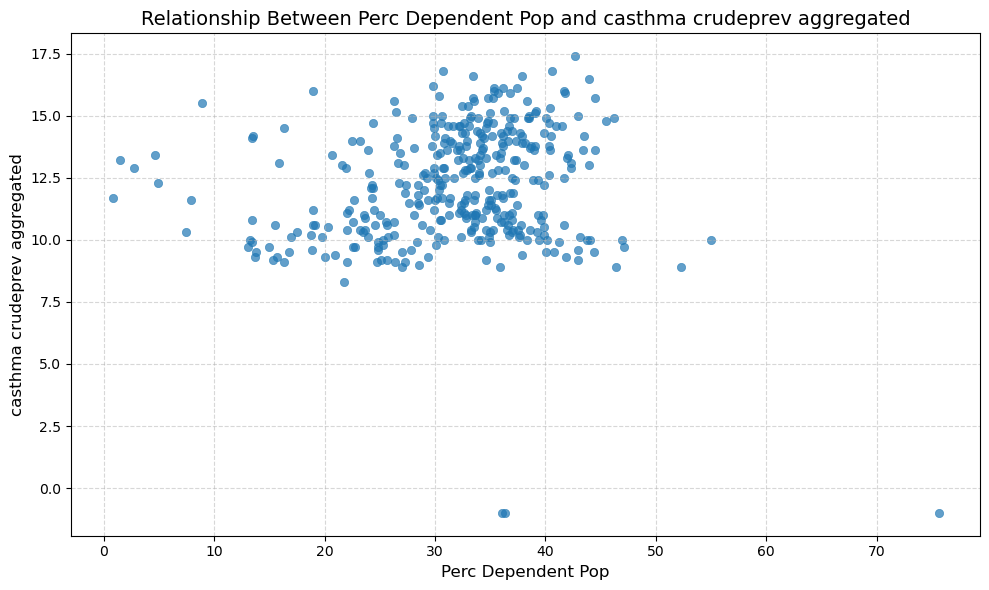

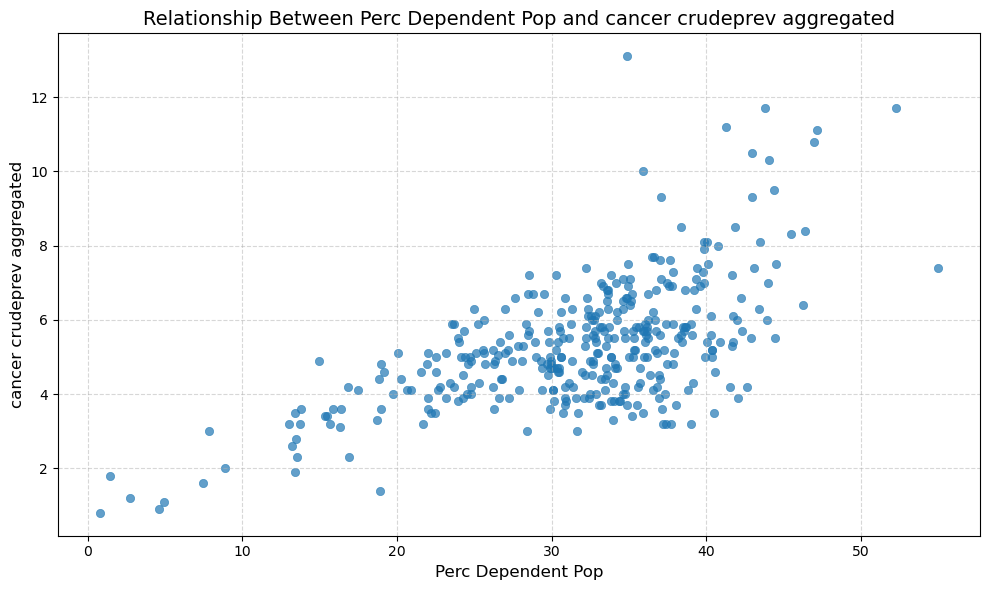

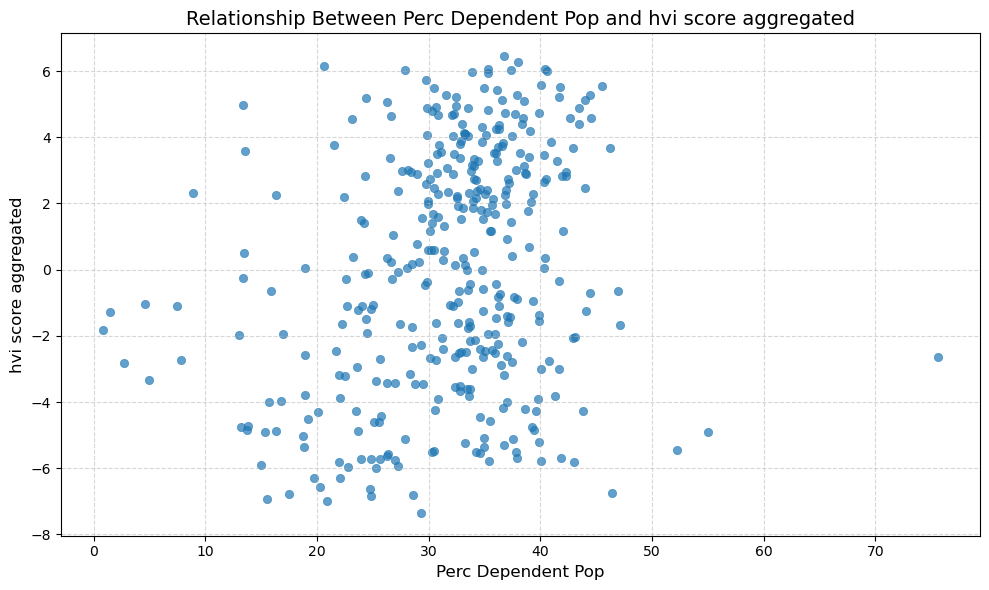

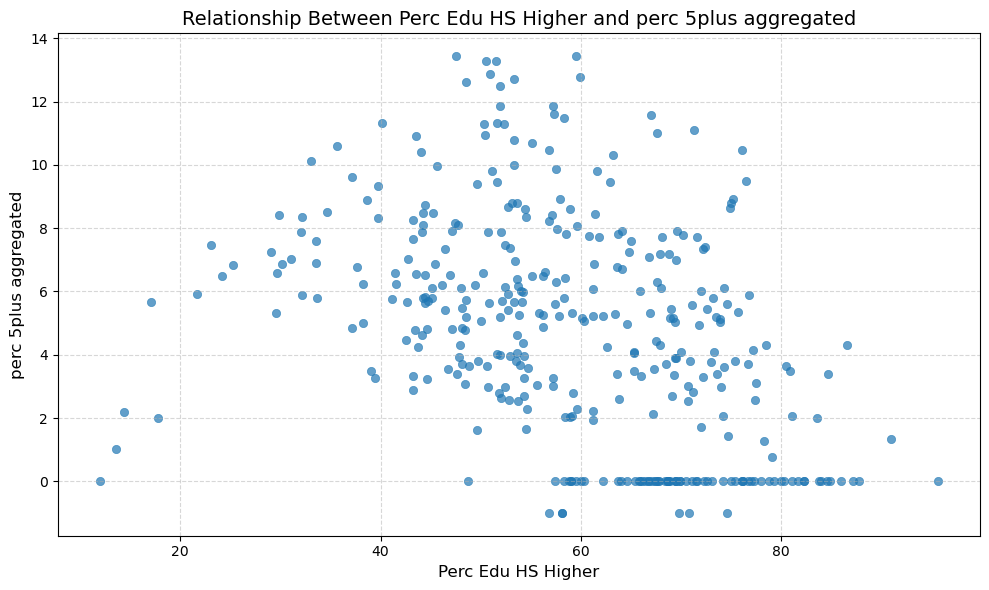

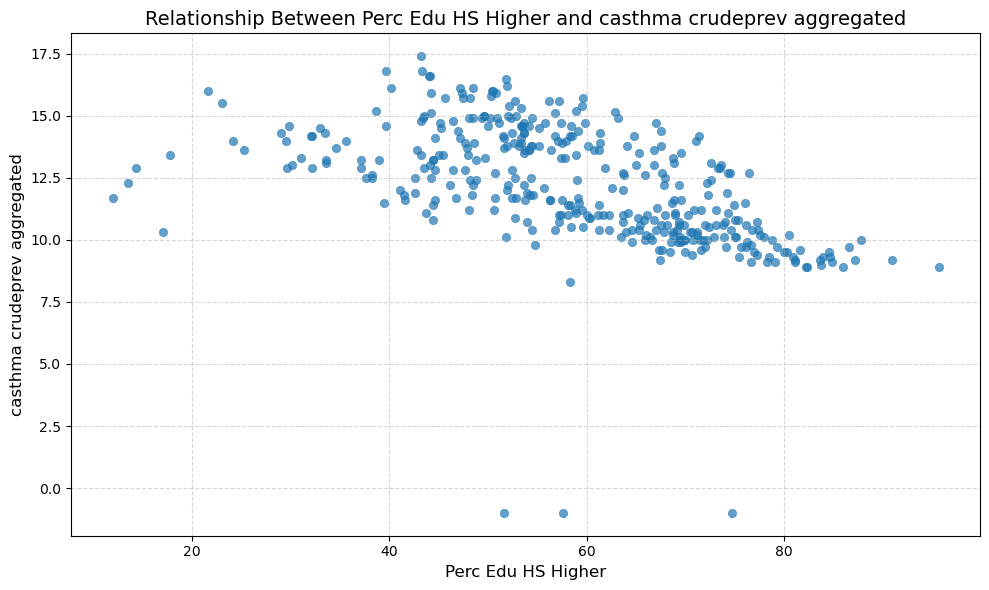

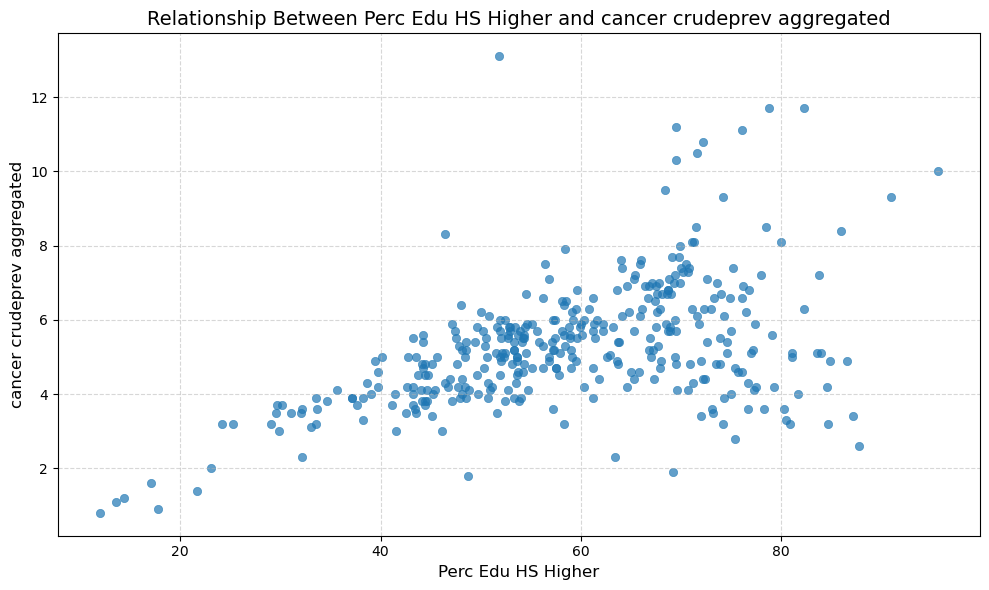

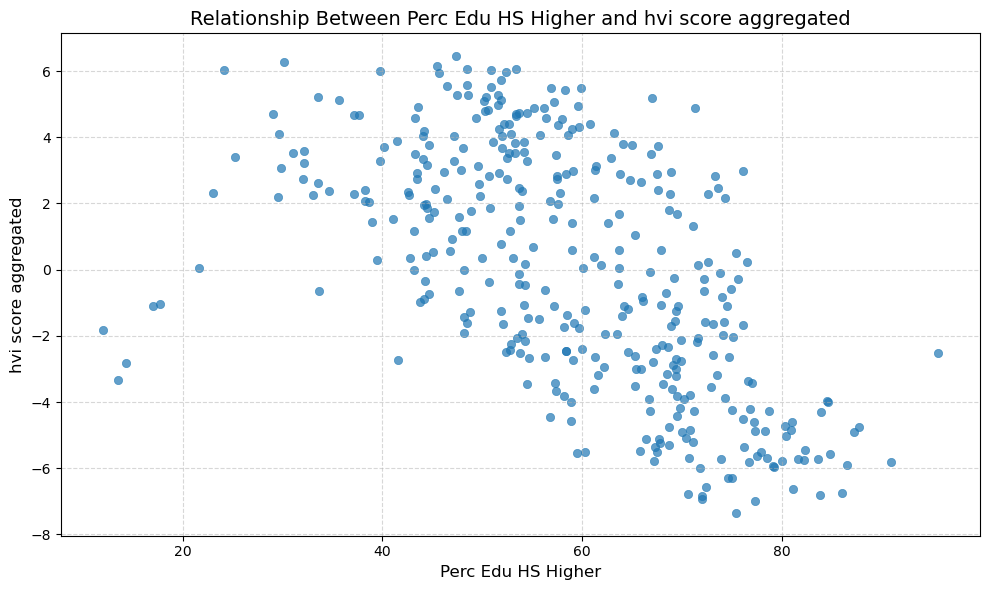

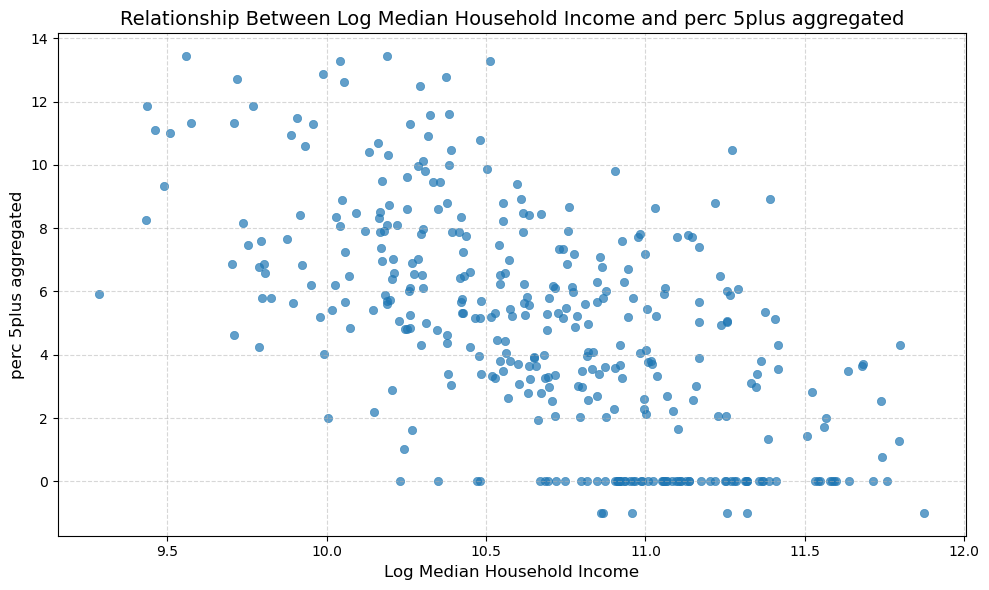

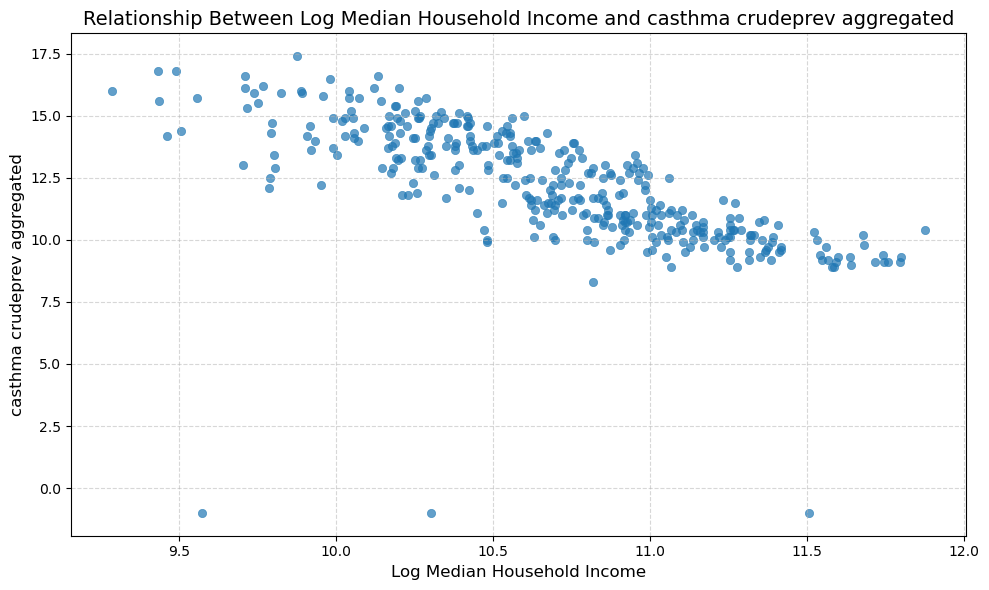

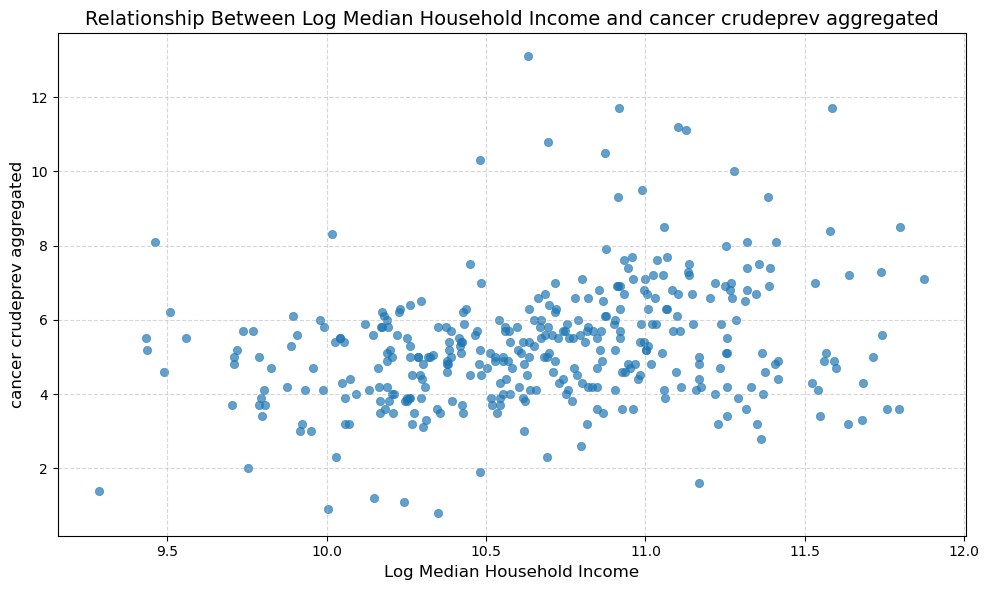

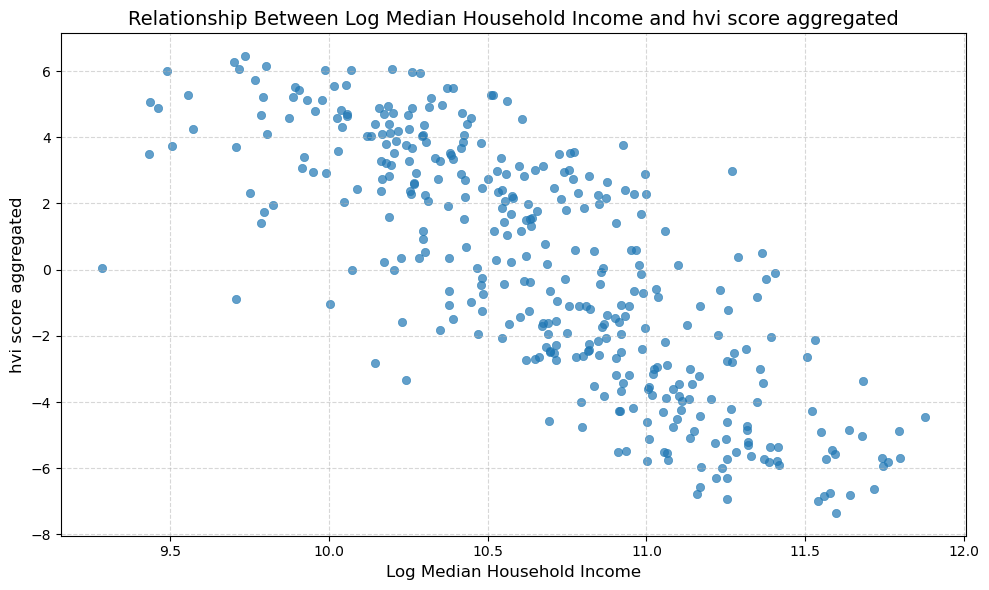

In [15]:
#| layout-ncol: 2

# Independent and dependent variables
independent_vars = ["Perc_Non_White", "Perc_Dependent_Pop", "Perc_Edu_HS_Higher", "Log_Median_Household_Income"]
dependent_vars = ["perc_5plus_aggregated", "casthma_crudeprev_aggregated", "cancer_crudeprev_aggregated", "hvi_score_aggregated"]

# Enhanced scatter plot generation
for indep in independent_vars:
    for dep in dependent_vars:
        try:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(data=combined_data, x=indep, y=dep, alpha=0.7, edgecolor=None)
            plt.title(f"Relationship Between {indep.replace('_', ' ')} and {dep.replace('_', ' ')}", fontsize=14)
            plt.xlabel(indep.replace('_', ' '), fontsize=12)
            plt.ylabel(dep.replace('_', ' '), fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error encountered while plotting {indep} vs {dep}: {e}")



We used scatter plot analysis to explore these relationships and provide insight into potential correlations. In this analysis, we logged median household income as it reduces the influence of extreme values and ensures a more normalized data distribution, facilitating a clearer interpretation of trends. This approach revealed positive and negative relationships between various variables, highlighting areas of concern and pointing to potential socio-environmental inequities in Philadelphia. 

This exploratory analysis underscored the spatial inequities present across Philadelphia, where socio-economic disadvantages and environmental risks intersect. Vulnerable neighborhoods—characterized by low income, low education levels, and high percentages of non-white residents—face disproportionate exposure to heat, asthma, and lead-related health risks. These initial insights laid the groundwork for further analysis, including scatter plot and clustering techniques, to better understand the relationships between socio-economic factors and environmental health outcomes.

By visualizing and statistically examining the datasets, we gained a clearer understanding of the challenges faced by different communities, allowing us to shape subsequent analyses toward identifying actionable solutions for addressing health inequities in Philadelphia.


## 2.4. Correlation Heatmap of Features

We utilized a correlation heatmap to visualize the Pearson correlation coefficients to deepen our understanding of the relationships between social, economic, and health-related features. This statistical measure quantifies the strength and direction of linear relationships between variables, with values ranging from -1 to 1:

- **1** indicates a perfect positive correlation, where both variables measure increase together
- **-1** indicates a perfect negative correlation, where one variable increases as another decreases
- **0** indicates no linear correlation between the variables

The correlation heatmap serves as a diagnostic tool, enabling us to:

- Identify strong positive correlations, where closely aligned variables tend to increase or decrease together.

- Identify strong negative correlations where variables move in opposite directions.

- Detect weak or no correlations, where variables have little to no linear relationship. This suggests other forms of association or independence. 


This helps in understanding the relationships between demographic indicators and health inequities, providing valuable insights for further analysis.

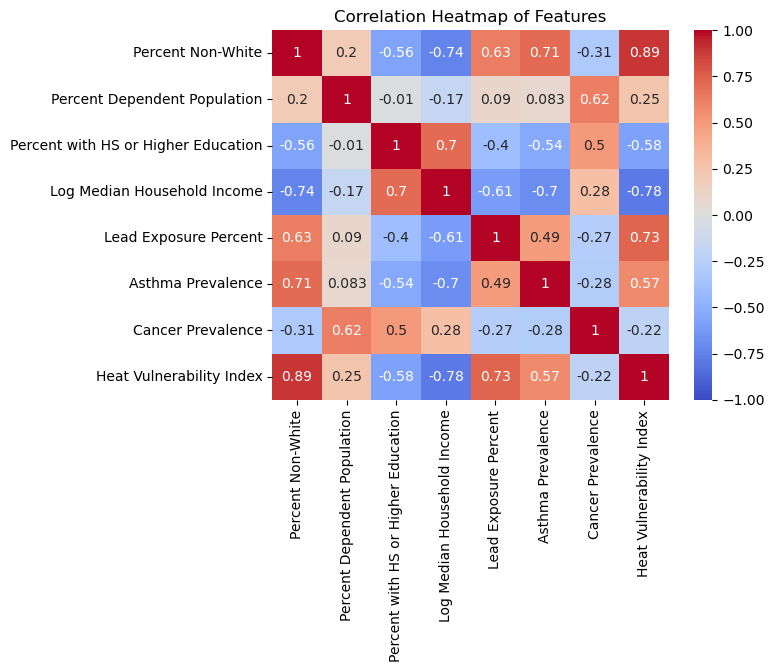

In [17]:
# Define the new column names as a dictionary
column_rename_map = {
    "Perc_Non_White": "Percent Non-White",
    "Perc_Dependent_Pop": "Percent Dependent Population",
    "Perc_Edu_HS_Higher": "Percent with HS or Higher Education",
    "Log_Median_Household_Income": "Log Median Household Income",
    "perc_5plus_aggregated": "Lead Exposure Percent",
    "casthma_crudeprev_aggregated": "Asthma Prevalence",
    "cancer_crudeprev_aggregated": "Cancer Prevalence",
    "hvi_score_aggregated": "Heat Vulnerability Index",
}

# Rename the columns in the dataset
renamed_data = combined_data.rename(columns=column_rename_map)

# Select only the renamed columns for the heatmap
feature_cols = list(column_rename_map.values())

# Plot the heatmap
sns.heatmap(
    renamed_data[feature_cols].corr(), 
    cmap="coolwarm", 
    annot=True, 
    vmin=-1, 
    vmax=1
)

# Add title and show the plot
plt.title("Correlation Heatmap of Features")
plt.show()


# Summary

In this section, we created a correlation heatmap with a diverging color scheme to highlight positive (red) and negative (blue) correlations, with white for near-zero correlations. The Pearson correlation coefficients are also displayed in this heatmap. Using this method, we identified the most relevant positive and negative relationships.

## Positive Relationships
1. **Percent of Non-White Population vs. Percent of Children Under 6 with High Blood Lead Levels**  
   - Correlation: **0.63**  
   - Census tracts with higher percentages of non-white populations experience higher rates of lead exposure among young children.

2. **Percent of Non-White Population vs. Prevalence of Current Asthma Among Adults**  
   - Correlation: **0.71**  
   - Asthma prevalence is higher in areas with larger non-white populations.

3. **Percent of Non-White Population vs. Heat Vulnerability Index (HVI) Score**  
   - Correlation: **0.89**  
   - Highlights significant overlap between racial demographics and heat vulnerability, emphasizing environmental justice concerns.

4. **Percent of Dependent Population vs. Prevalence of Cancer Among Adults**  
   - Correlation: **0.62**  
   - Areas with higher proportions of dependent populations (children and older adults) also experience higher cancer prevalence.

## Negative Relationships
1. **Percent of High Educational Attainment vs. Percent of Children Under 6 with High Blood Lead Levels**  
   - Correlation: **-0.40**  
   - Higher educational attainment is associated with lower rates of childhood lead exposure.

2. **Percent of High Educational Attainment vs. Prevalence of Current Asthma Among Adults**  
   - Correlation: **-0.54**  
   - Areas with higher education attainment tend to have lower asthma prevalence.

3. **Percent of High Educational Attainment vs. HVI Score**  
   - Correlation: **-0.58**  
   - Higher educational attainment is linked to lower heat vulnerability scores.

4. **Median Household Income (Logged) vs. Percentage of Children Under 6 with High Blood Lead Levels**  
   - Correlation: **-0.61**  
   - Higher household incomes are linked to lower childhood lead exposure.

5. **Median Household Income (Logged) vs. Prevalence of Current Asthma Among Adults**  
   - Correlation: **-0.70**  
   - Reflects the inverse relationship between income levels and asthma prevalence.

6. **Median Household Income (Logged) vs. HVI Score**  
   - Correlation: **-0.78**  
   - Highlights that higher-income areas are less vulnerable to heat-related risks.

---

## Key Patterns and Implications

1. **Environmental Benefits in Wealthier Areas**  
   - A strong positive correlation exists between **median household income** and **tree canopy coverage**, suggesting environmental benefits are more prevalent in wealthier areas.

2. **Socioeconomic Disadvantages and Health Inequities**  
   - Negative correlations between socioeconomic disadvantages (e.g., poverty, dependent populations) and health equity indicators underscore areas of concern for public health initiatives.

3. **Complex Relationships**  
   - Weak correlations, such as between **tree canopy** and **asthma rates**, suggest the need for further investigation into non-linear or indirect relationships.

---

## Actionable Insights

Given the initial findings, the heatmaps provide valuable guidance for targeted interventions:

- **Urban Greening Programs:** Focus on areas with high poverty and low tree canopy coverage.

- **Lead Abatement Efforts:** Prioritize areas with high child blood lead levels and low income.  

By integrating this analysis, we establish a foundation for exploring the relationships between socioeconomic and demographic characteristics with health outcomes, ultimately improving equitable public health and environmental justice outcomes.

---

## Conclusion

These findings illustrate the disproportionate environmental and health challenges faced by marginalized communities, particularly those with higher percentages of **non-white** and **lower-income populations**. The relationships emphasize the need for targeted interventions to address these inequities and strive for environmental justice across Philadelphia.


In [20]:
#| echo: false
#| output: false

%store combined_data

Stored 'combined_data' (GeoDataFrame)
